In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from scipy import stats
from unidecode import unidecode
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2_contingency
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from datasets import load_dataset
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import make_pipeline

In [3]:
# Load the dataset without missing values
dataset_cyclists = load_dataset('csv', data_files='df_cyclists_no_missing.csv')
dataset_races = load_dataset('csv', data_files='df_races_no_missing.csv')

# Convert to pandas DataFrames
df_cyclists = dataset_cyclists['train'].to_pandas()
df_races = dataset_races['train'].to_pandas()

df_races.isnull().sum()

Generating train split: 6094 examples [00:00, 101915.85 examples/s]
Generating train split: 589813 examples [00:02, 232808.96 examples/s]


_url                 0
name                 0
points               0
uci_points           0
length               0
climb_total          0
profile              0
startlist_quality    0
date                 0
position             0
cyclist              0
cyclist_age          0
is_tarmac            0
is_cobbled           0
is_gravel            0
cyclist_team         0
delta                0
year                 0
dtype: int64

In [4]:
df_cyclists.head()

,_url,birth_year,weight,height,nationality
0,bruno-surra,1964.0,68.805369,183.902338,Italy
1,gerard-rue,1965.0,74.000000,182.000000,France
2,jan-maas,1996.0,69.000000,189.000000,Netherlands
3,nathan-van-hooydonck,1995.0,78.000000,192.000000,Belgium
4,jose-felix-parra,1997.0,55.000000,171.000000,Spain


In [5]:
df_races.head()

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta,year
0,amstel-gold-race/1970/result,Amstel Gold Race,225.0,400.0,240000.0,3941.0,2.0,372.0,1970-04-25,0,georges-pintens,24.0,False,False,False,norway-1987,0.0,1970.0
1,amstel-gold-race/1970/result,Amstel Gold Race,225.0,400.0,240000.0,3941.0,2.0,372.0,1970-04-25,1,willy-van-neste,26.0,False,False,False,norway-1987,0.0,1970.0
2,amstel-gold-race/1970/result,Amstel Gold Race,225.0,400.0,240000.0,3941.0,2.0,372.0,1970-04-25,2,andre-dierickx,23.0,False,False,False,spain-1991,22.0,1970.0
3,amstel-gold-race/1970/result,Amstel Gold Race,225.0,400.0,240000.0,3941.0,2.0,372.0,1970-04-25,3,eric-leman,24.0,False,False,False,spain-1991,11.0,1970.0
4,amstel-gold-race/1970/result,Amstel Gold Race,225.0,400.0,240000.0,3941.0,2.0,372.0,1970-04-25,4,joseph-schoeters,23.0,False,False,False,netherlands-1974,0.0,1970.0


# Creating novel features

Create Body Mass Index from height and weight

In [6]:
df_cyclists['BMI'] = df_cyclists['weight'] / (df_cyclists['height'] / 100) ** 2
df_cyclists['BMI'].head()

0    20.344538
1    22.340297
2    19.316369
3    21.158854
4    18.809206
Name: BMI, dtype: float64

# Race difficulty 
From climb total and profile we create this metric. It is weighted since profile are values from 1 to 5, acting as weights.
We normalize it, creating a score in the range [0,1], because if we have a weights of 1, the product will result in a redundant information equal to climb_total

In [7]:
# Convert profile as an integer
df_races["profile"] = df_races["profile"].astype(int)

In [8]:
# Compute Race Difficulty  
df_races['race_difficulty'] = df_races['climb_total'] * df_races['profile'] 

# Normalize in the range [0,1]
df_races['race_difficulty'] = (df_races['race_difficulty'] - df_races['race_difficulty'].min()) / \
                                     (df_races['race_difficulty'].max() - df_races['race_difficulty'].min())


# Display race_difficulty
df_races[['name', 'climb_total', 'profile', 'race_difficulty']]

,name,climb_total,profile,race_difficulty
0,Amstel Gold Race,3941.0,2,0.225995
1,Amstel Gold Race,3941.0,2,0.225995
2,Amstel Gold Race,3941.0,2,0.225995
3,Amstel Gold Race,3941.0,2,0.225995
4,Amstel Gold Race,3941.0,2,0.225995
...,...,...,...,...
589808,World Championships - Road Race,4167.0,2,0.238958
589809,World Championships - Road Race,4167.0,2,0.238958
589810,World Championships - Road Race,4167.0,2,0.238958
589811,World Championships - Road Race,4167.0,2,0.238958


# Team strength 
Groups the data by each team. Then, compute the sum or the average of startlist_quality values for all cyclists within the same team. The sum represents the total strength of the team, while the average gives a sense of the average strength per cyclist in the team. We know that the startlist_quality might vary from race to race, as different races might have different levels of competition or difficulty. Thus, if a team participates in both high-quality and low-quality races within the same period, the team strength will aggregate both types of races.

Here, the strength is calculated first all over the years. This could make sense because teams are ofter historical. So, even if they changed over 20 years, an overall statistic on the importance/famousness of that team can be useful.

In addition, we can divide the years in 70's, 80's, 90's and from 2000-2023 and calculate the strength for each team but in different cycling years. This information will be stored in another dataset called team_cyclist_strength

In [9]:
df_races["year"].unique()

array([1970., 1971., 1972., 1973., 1974., 1975., 1976., 1977., 1978.,
       1979., 1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987.,
       1988., 1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996.,
       1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005.,
       2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014.,
       2015., 2016., 2017., 2018., 2019., 2021., 2022., 2023., 2020.])

In [10]:
print(df_races["year"].min())
print(df_races["year"].max())

# anni 70
# anni 80
# anni 90
# anni 2000

1970.0
2023.0


In [11]:
# Step 1: Group by 'cyclist_team' and get the unique years for each team
team_years = df_races.groupby('cyclist_team')['year'].unique().reset_index()

# Step 2: Sort the years in ascending order for each team
team_years['year'] = team_years['year'].apply(lambda years: sorted(years))

# Step 3: Display the results
team_years[['cyclist_team', 'year']]

,cyclist_team,year
0,ag2r-prevoyance-2001,"[1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975...."
1,atala-1985,"[1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975...."
2,atala-campagnolo-1983,"[1970.0, 1971.0, 1973.0, 1974.0, 1975.0, 1976...."
3,atala-ofmega-1988,"[1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981...."
4,australia-1983,"[1970.0, 1971.0, 1972.0, 1973.0, 1975.0, 1976...."
...,...,...
86,united-states-1998,"[1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975...."
87,ville-de-charleroi-new-systems-2000,"[1970.0, 1971.0, 1974.0, 1975.0, 1976.0, 1977...."
88,vini-fantini-2013,"[1970.0, 1971.0, 1972.0, 1975.0, 1976.0, 1978...."
89,vini-ricordi-pinarello-sidermec-1986,"[1970.0, 1971.0, 1972.0, 1974.0, 1975.0, 1976...."


Here, there are some teams called, for example, "sport-vlaanderen-baloise-2021". This might be a team that raced in the 1980s but carried the sponsorship or team name "Sport Vlaanderen Baloise" starting in 2021. So we leave this way because probably the dataset represents older teams with new name

# For all years (historical)
Stored directly in df_races dataset

In [12]:
# Calculate the average of startlist_quality per team
df_races['team_avg_strength'] = df_races.groupby('cyclist_team')['startlist_quality'].transform('mean')

# Display the result 
df_races[['cyclist_team', 'year', 'team_avg_strength']].drop_duplicates()

,cyclist_team,year,team_avg_strength
0,norway-1987,1970.0,1117.306216
2,spain-1991,1970.0,1098.066569
4,netherlands-1974,1970.0,1121.314981
5,ville-de-charleroi-new-systems-2000,1970.0,1094.417177
6,teka-1988,1970.0,1060.581229
...,...,...,...
586164,finland-2016,1976.0,1153.610750
586184,team-volksbank-2008,1976.0,1132.725108
589134,new-zealand-1991,2014.0,1080.129398
589135,ag2r-prevoyance-2001,2014.0,1111.636924


# Done by year (new dataset)

In [13]:
# Create a new column for the time period (decades)
def get_period(year):
    if 1970 <= year <= 1979:
        return '1970s'
    elif 1980 <= year <= 1989:
        return '1980s'
    elif 1990 <= year <= 1999:
        return '1990s'
    elif 2000 <= year <= 2023:
        return '2000-2023'
    else:
        return 'Before 1970'

# Create decades period column of rafces in the dataset
df_races['period'] = df_races['year'].apply(get_period)

# Compute team strength (sum) and average startlist_quality for each team and period
team_strength = df_races.groupby(['cyclist_team', 'period'])['startlist_quality'].agg(['mean']).reset_index()

# Rename the columns to make it clear
team_strength.rename(columns={'mean': 'team_avg_strength'}, inplace=True)

# Display the new dataset with team name, period, and computed strength
team_strength

# Save it
#team_strength.to_csv('team_avg_trength_per_period.csv', index=False)

,cyclist_team,period,team_avg_strength
0,ag2r-prevoyance-2001,1970s,941.570423
1,ag2r-prevoyance-2001,1980s,1284.537393
2,ag2r-prevoyance-2001,1990s,1318.799051
3,ag2r-prevoyance-2001,2000-2023,1049.316175
4,atala-1985,1970s,876.431193
...,...,...,...
356,vini-ricordi-pinarello-sidermec-1986,2000-2023,1051.402019
357,watney-avia-1972,1970s,768.316176
358,watney-avia-1972,1980s,1345.368354
359,watney-avia-1972,1990s,1328.937304


Here, we can gain useful insights for each team. For example, we can infer that some teams has become more powerful over the years. But this is reasonable or it is due to some inconsistency in the data ? We plot some distribution to give us an idea on how teas grows over the years

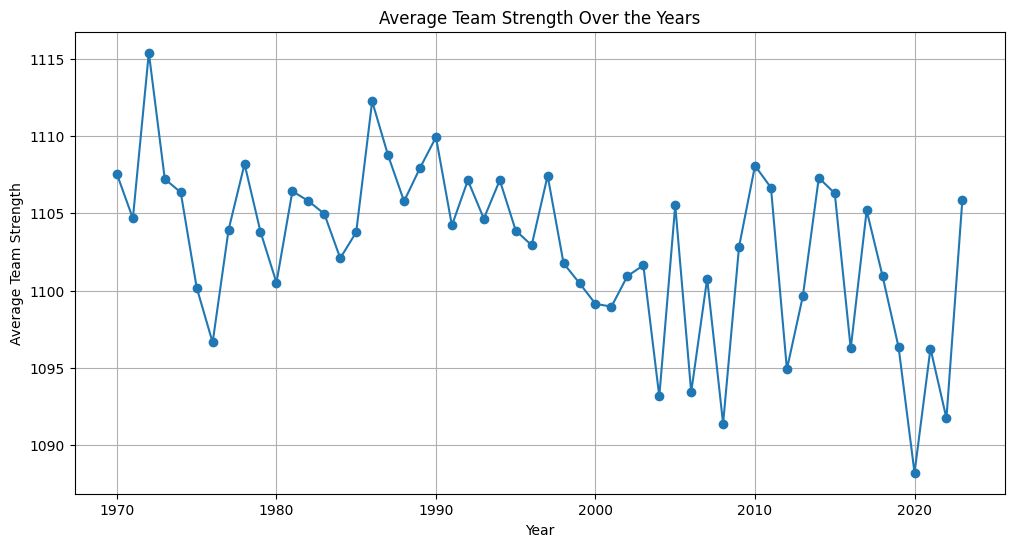

In [14]:
# Group by year and calculate the average strength for each year
yearly_avg_strength = df_races.groupby('year')['team_avg_strength'].mean().reset_index()

# Plot the trend of team average strength over the years
plt.figure(figsize=(12, 6))
plt.plot(yearly_avg_strength['year'], yearly_avg_strength['team_avg_strength'], marker='o', linestyle='-')
plt.title('Average Team Strength Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Team Strength')
plt.grid(True)
plt.show()

Seems that over the years, in the 70's there were better cyclists

# Examine the Correlation Between startlist_quality and years

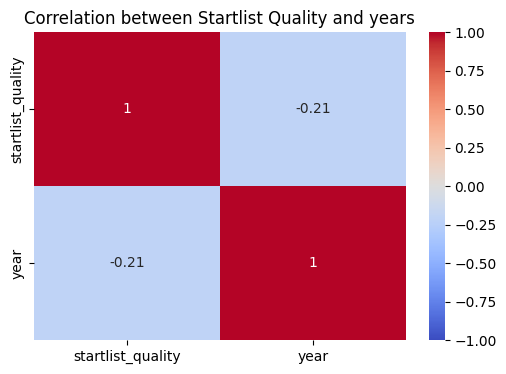

In [15]:
# Compute the correlation between startlist_quality and race difficulty
correlation = df_races[['startlist_quality', 'year']].corr()

# Plot
plt.figure(figsize=(6, 4))
seaborn.heatmap(correlation, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title('Correlation between Startlist Quality and years')
plt.show()

As expected, there is a little correlation between them, with can reflect the plot did before. We have also to consider that a team might appear stronger over time simply because they have better sponsorship, and this could be reflected in the startlist_quality metric over that year.

# Bias of avg strength: there is a Trade off

- With a simple Mean (No Weighting) we treat all races equally, regardless of prestige. This reduces the prestige bias but could result in misleadingly high strength values for teams that primarily compete in easier, low-prestige events.

- With a Weighted Mean (using points as weights) we emphasizes high-prestige races, potentially better reflecting the strength of teams that regularly compete in top-tier events. However, it may undervalue teams that race mainly in low-prestige events

# Features for clustering
We want to distinguish between:

- Climbers: High PWR, good climbing efficiency, high Race Intensity preference.
- Sprinters/Bouncers: Lower PWR but higher Position Consistency, low Climb-to-Length Ratio.
- All-Rounders/Baroudeurs: Moderate scores across features, strong Prestige-Weighted Delta, better on mixed surfaces.

## BMI (calculated above)
Useful for spot sprinters that have more compact physiques compared to climbers

## Cyclist Consistency

consistency = top_3_frequency_percentage/(finish_pos_std + 1)*(delta_std + 1)

Compute metrics used in the consistency

In [16]:
# Make the position an integer
df_races["position"] = df_races["position"].astype(int)

# Group by 'cyclist' and aggregate 'position' into a list
cyclist_positions = df_races.groupby('cyclist')['position'].apply(list).reset_index()

# Rename the column for clarity
cyclist_positions.rename(columns={'position': 'positions_per_race'}, inplace=True)

# Display the result
cyclist_positions


,cyclist,positions_per_race
0,aad-van-den-hoek,"[20, 106, 37, 26, 71, 14, 26, 14, 39, 28, 73, ..."
1,aaron-gate,"[135, 127, 57, 13, 47, 79, 8, 93, 78, 20, 61, ..."
2,aaron-kemps,"[82, 67, 129, 76, 24, 59, 3, 87, 118, 2, 85, 1..."
3,aaron-olsen,"[173, 189, 140, 166, 165, 160, 125, 155, 130, ..."
4,aaron-van-poucke,"[99, 36, 93, 135, 53, 91, 101]"
...,...,...
6089,zenon-jaskula,"[62, 21, 4, 9, 3, 8, 6, 7, 8, 5, 7, 9, 7, 7, 1..."
6090,zhandos-bizhigitov,"[64, 168, 103, 123, 163, 157, 172, 169, 157, 1..."
6091,zico-waeytens,"[87, 145, 169, 141, 118, 140, 62, 140, 109, 15..."
6092,zoran-klemencic,"[163, 71, 10, 140, 1, 122, 138, 117, 4, 161, 1..."


In [17]:
# Step 1: Count the number of positions per cyclist
cyclist_counts = df_races.groupby('cyclist')['position'].count()

# Step 2: Identify cyclists with more than one position
multi_position_cyclists = cyclist_counts[cyclist_counts > 1].index

# Step 3: Filter `df_races` to keep only rows with these cyclists
df_races = df_races[df_races['cyclist'].isin(multi_position_cyclists)]

# Display the result
print("Updated df_races without cyclists who have only one position:")
print(df_races)


Updated df_races without cyclists who have only one position:
                                  _url                             name  \
0         amstel-gold-race/1970/result                 Amstel Gold Race   
1         amstel-gold-race/1970/result                 Amstel Gold Race   
2         amstel-gold-race/1970/result                 Amstel Gold Race   
3         amstel-gold-race/1970/result                 Amstel Gold Race   
4         amstel-gold-race/1970/result                 Amstel Gold Race   
...                                ...                              ...   
589808  world-championship/2022/result  World Championships - Road Race   
589809  world-championship/2022/result  World Championships - Road Race   
589810  world-championship/2022/result  World Championships - Road Race   
589811  world-championship/2022/result  World Championships - Road Race   
589812  world-championship/2022/result  World Championships - Road Race   

        points  uci_points    length 

In [18]:
# The variability in the cyclist's finish positions across races
df_races['finish_position_std'] = df_races.groupby('cyclist')['position'].transform('std')

# How close a cyclist consistently finishes relative to the race winner
df_races['avg_delta'] = df_races.groupby('cyclist')['delta'].transform('mean')

# How variable the time gaps are
df_races['delta_std'] = df_races.groupby('cyclist')['delta'].transform('std')

# How often a cyclist finishes in the top 10 positions
# Define a top X threshold, e.g., top 5
top_x_threshold = 10
df_races['top_x_finish'] = df_races['position'] <= top_x_threshold
df_races['top_x_finish_percentage'] = df_races.groupby('cyclist')['top_x_finish'].transform('mean')

# Calculate the consistency score
df_races['consistency_score'] = (
    1 / (df_races['finish_position_std'] + 1) *
    1 / (df_races['delta_std'] + 1) *
    df_races['top_x_finish_percentage']
)

## Power-to-Weight Ratio (PWR)
- Climbers tend to have high PWR because they optimize for lighter body weight and high power output, which is ideal for uphill efforts.
- Sprinters, on the other hand, may have lower PWR because their racing style emphasizes quick, powerful bursts

In [19]:
# Merge df_races and df_cyclists on 'cyclist' and '_url' keys
merged_df = pd.merge(df_races, df_cyclists, left_on='cyclist', right_on='_url', how='left')

# Compute PWR (uci_points / weight), handling cases where weight might be zero or missing
merged_df['PWR'] = merged_df["uci_points"]/merged_df["weight"]

#merged_df[['cyclist', 'PWR']].head()

## Climbing Efficiency
We want to compute a score that reason in this way: lower values may indicate better climbing ability. If I arrive as first and climb_total is high, the results is lower, but if I arrive as 30's and climb total is the same value as before, the score will be higher. This could be captured by a simple ratio finish_position/climb_total

In [20]:
# Compute Climbing efficiency (final_position / climb_total)
merged_df['climb_efficiency'] = merged_df["position"]+1/merged_df["climb_total"]

merged_df[['cyclist', 'climb_efficiency']].head()

,cyclist,climb_efficiency
0,georges-pintens,0.000254
1,willy-van-neste,1.000254
2,andre-dierickx,2.000254
3,eric-leman,3.000254
4,joseph-schoeters,4.000254


## Time gap 
delta/length: Lower values may capture stronger performance across the race (for all-rounders cyclists)

In [21]:
# Compute Time gap feature (delta / length)
merged_df['time_gap'] = merged_df["delta"]/merged_df["length"]

merged_df[['cyclist', 'time_gap']]

,cyclist,time_gap
0,georges-pintens,0.000000
1,willy-van-neste,0.000000
2,andre-dierickx,0.000092
3,eric-leman,0.000046
4,joseph-schoeters,0.000000
...,...,...
589105,daan-hoole,0.000000
589106,ben-turner,0.000045
589107,pavel-sivakov,0.000629
589108,jake-stewart,0.000139


## Prestige-Weighted Delta
Measures the cyclist's relative performance to the race prestige, which may help identify cyclists who excel in high-profile, competitive races

In [22]:
# Compute Prestige weighted delta feature (delta / points)
merged_df['prestige_weighted_delta'] = merged_df["delta"]/merged_df["points"]

merged_df[['cyclist', 'prestige_weighted_delta']]

,cyclist,prestige_weighted_delta
0,georges-pintens,0.000000
1,willy-van-neste,0.000000
2,andre-dierickx,0.097778
3,eric-leman,0.048889
4,joseph-schoeters,0.000000
...,...,...
589105,daan-hoole,0.000000
589106,ben-turner,0.034286
589107,pavel-sivakov,0.480000
589108,jake-stewart,0.105714


In [23]:
df_races.isnull().sum()

_url                       0
name                       0
points                     0
uci_points                 0
length                     0
climb_total                0
profile                    0
startlist_quality          0
date                       0
position                   0
cyclist                    0
cyclist_age                0
is_tarmac                  0
is_cobbled                 0
is_gravel                  0
cyclist_team               0
delta                      0
year                       0
race_difficulty            0
team_avg_strength          0
period                     0
finish_position_std        0
avg_delta                  0
delta_std                  0
top_x_finish               0
top_x_finish_percentage    0
consistency_score          0
dtype: int64

In [24]:
merged_df.isnull().sum()

_url_x                     0
name                       0
points                     0
uci_points                 0
length                     0
climb_total                0
profile                    0
startlist_quality          0
date                       0
position                   0
cyclist                    0
cyclist_age                0
is_tarmac                  0
is_cobbled                 0
is_gravel                  0
cyclist_team               0
delta                      0
year                       0
race_difficulty            0
team_avg_strength          0
period                     0
finish_position_std        0
avg_delta                  0
delta_std                  0
top_x_finish               0
top_x_finish_percentage    0
consistency_score          0
_url_y                     0
birth_year                 0
weight                     0
height                     0
nationality                0
BMI                        0
PWR                        0
climb_efficien

In [25]:
df_cyclists.isnull().sum()

_url           0
birth_year     0
weight         0
height         0
nationality    0
BMI            0
dtype: int64

# Save updated datasets

In [26]:
# Races
df_races.to_csv('df_races_FE.csv', index=False)

# Cyclists
df_cyclists.to_csv('df_cyclists_FE.csv', index=False)

# Merged
merged_df.to_csv('merged_FE.csv', index=False)